# Анализ сервиса самокатов GoFast

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. Пути к файлам:
- /datasets/users_go.csv
- /datasets/rides_go.csv
- /datasets/subscriptions_go.csv

Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

Загрузим users_go.csv и изучим данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')

In [3]:
data_users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Можно отметить, что первые строки имеют все ультра подписку, в предобработке данных следует уточнить этот момент

Загрузим rides_go.csv и изучим данные

In [5]:
data_rides = pd.read_csv('/datasets/rides_go.csv')

In [6]:
data_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [7]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Видно, что date имеет неверный тип данных, в предобработке исправим

Загрузим subscriptions_go.csv

In [8]:
data_subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [9]:
data_subs.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В этом дф просто информация о подписках

Итого можно заметить, что пустых строк предварительно нет, но они могут быть заполнены чем-то другим, что в последствии увидим

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas.

In [11]:
# приведем тип к датам
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')
# проверим
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создайте новый столбец с номером месяца на основе столбца date.

In [12]:
data_rides['date'].dt.year.unique()

array([2021])

In [13]:
data_rides['month_number'] = data_rides['date'].dt.month
data_rides.head()

,user_id,distance,duration,date,month_number
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

Обработаем сначала users_go

In [14]:
# удалим явные дубликаты
print(len(data_users))
data_users = data_users.drop_duplicates()
print(len(data_users))

1565
1534


31 аккаунт являлись дубликатами

In [15]:
# проверим на повторение id
data_users['user_id'].value_counts()

1       1
1020    1
1029    1
1028    1
1027    1
       ..
510     1
509     1
508     1
507     1
1534    1
Name: user_id, Length: 1534, dtype: int64

Каждый пользователь зарегистрирован в одном городе

In [16]:
# проверим столбец с именами на имя, заполняющее путую строку
data_users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

In [17]:
# сделаем тоже самое для городов
data_users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [18]:
#Посмотрим что с подписками
data_users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Имен и городов, которыми бы заполняли пропуски, не вижу

Значит <b>дубликатов и пропусков</b> больше нет

Теперь проверим rides_go.csv

In [19]:
# удалим явные дубликаты
print(len(data_rides))
data_rides = data_rides.drop_duplicates()
print(len(data_rides))

18068
18068


Их не оказалось

In [20]:
# округлим дистанции и времена поездок
data_rides['distance_round'] = data_rides['distance'].apply(np.ceil).astype(int)
data_rides['duration_round'] = data_rides['duration'].apply(np.ceil).astype(int)
data_rides.head()

,user_id,distance,duration,date,month_number,distance_round,duration_round
0,1,4409.919140,25.599769,2021-01-01,1,4410,26
1,1,2617.592153,15.816871,2021-01-18,1,2618,16
2,1,754.159807,6.232113,2021-04-20,4,755,7
3,1,2694.783254,18.511000,2021-08-11,8,2695,19
4,1,4028.687306,26.265803,2021-08-28,8,4029,27


In [21]:
# посмотрим есть ли выбивающиеся значения по дистанции
data_rides['distance_round'].sort_values().unique()

array([   1,    3,    5, ..., 6909, 7067, 7212])

In [22]:
# посмотрим есть ли выбивающиеся значения по длительности
data_rides['duration_round'].sort_values().unique()

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41])

Выбивающихся значений не оказалось, данные чисты

#### Шаг 3. Исследовательский анализ данных

##### частота встречаемости городов

In [23]:
# посмотрим сколько всего аккаунтов в каких городах
freqs_city = data_users['city'].value_counts()
freqs_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

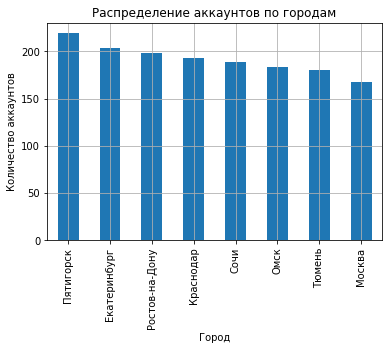

In [24]:
# визуализируем полученные данные
ax = freqs_city.plot.bar()
ax.set_title('Распределение аккаунтов по городам')
ax.set_xlabel('Город')
ax.set_ylabel('Количество аккаунтов')
ax.grid(True)
plt.show()

Самое большое количество аккаунтов в Пятигорске, наименьшее в Москве, однако в целом количество примерно одинаковое

##### Соотношение пользователей с подпиской и без подписки;

In [25]:
freqs_subs = data_users['subscription_type'].value_counts()
freqs_subs

free     835
ultra    699
Name: subscription_type, dtype: int64

In [26]:
# какой процент с бесплатной подпиской
percent_free = data_users[data_users['subscription_type'] == 'free'].count() / len(data_users['subscription_type'])
percent_free

user_id              0.544329
name                 0.544329
age                  0.544329
city                 0.544329
subscription_type    0.544329
dtype: float64

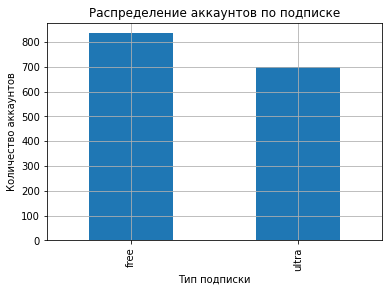

In [27]:
# визуализируем полученные данные
ax = freqs_subs.plot.bar()
ax.set_title('Распределение аккаунтов по подписке')
ax.set_xlabel('Тип подписки')
ax.set_ylabel('Количество аккаунтов')
ax.grid(True)
plt.show()

<AxesSubplot:ylabel='user_id'>

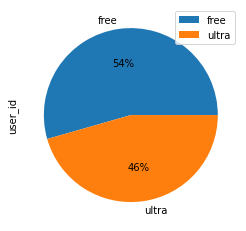

In [28]:
data_users.groupby(['subscription_type']).count().plot(kind='pie', y='user_id', autopct='%1.0f%%')

54.4% пользователей имеют бесплатную подписку, 45.6% имеют подписку ультра

##### Возраст пользователей;

In [29]:
# Найдем минимальный и максимальный возраст для уточнения гистограммы
maxim_age = data_users['age'].max()
min_age = data_users['age'].min()
maxim_age, min_age

(43, 12)

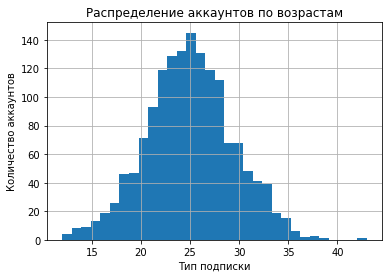

In [30]:
# построим гистограмму для возрастов
ax = data_users['age'].plot.hist(bins=32)
ax.set_title('Распределение аккаунтов по возрастам')
ax.set_xlabel('Тип подписки')
ax.set_ylabel('Количество аккаунтов')
ax.grid(True)
plt.show()

In [31]:
# список возрастов и их количество
data_users['age'].value_counts()

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

Итого получаем, что минимальный возраст пользователей 12 лет, максимальный 43, большинство людей - 20-летние люди

##### расстояние, которое пользователь преодолел за одну поездку

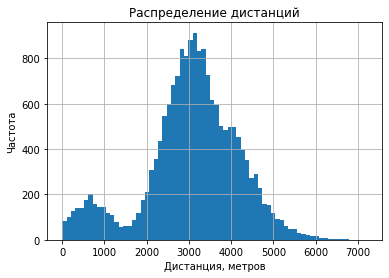

In [32]:
# построим гистограмму дистанций
ax = data_rides['distance_round'].plot.hist(bins = 70)
ax.set_title('Распределение дистанций')
ax.set_xlabel('Дистанция, метров')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()

In [33]:
more_1500 = len(data_rides.query('distance_round >= 1500'))
less_1500 = len(data_rides.query('distance_round < 1500'))
all_rides = len(data_rides)
print(f'Доля коротких поездок: {less_1500/all_rides}')
print(f'Доля длинных поездок: {more_1500/all_rides}')

Доля коротких поездок: 0.09934691166703565
Доля длинных поездок: 0.9006530883329643


Видно, что большинство людей проезжают порядка 3 км, однако есть еще локальный пик в районе 500 метров, т.е. можно разделить поездки на 2 типа: короткая (500 м) и долгая (3 км)

Очень странное поведение для крайне малых расстояний, вполне возможно люди по ошибке бронировали самокат, возможно они пробывали 1 раз и сразу же бросали поездку

##### продолжительность поездок.

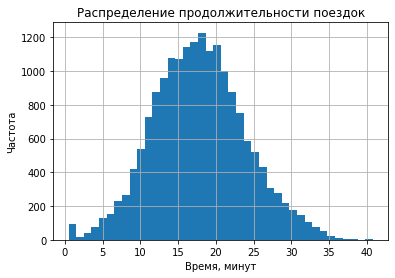

In [34]:
ax = data_rides['duration'].plot.hist(bins = 40)
ax.set_title('Распределение продолжительности поездок')
ax.set_xlabel('Время, минут')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()

Большинство поездок длится около 18 минут, график распределен нормально. Однако в районе 0 есть небольшой пик, который пока что не буду удалять, т.к. если нужно будет считать выручку, то люди без подписки внесли свою оплату за начало движения. Если строить отдельно для людей с подпиской такой график, то стоит убрать 0 минут.

<b>Итого получаем</b>:
- города распределены примерно одинаково, разница между самым активным в плане использования (Пятигорском) и самым неактивным (Москва) невелика (219 и 168 соответственно)
- людей с подпиской 45.6% среди всех пользователей
- самые активные юзеры самокатов молодые люди в возрасте от 20 до 30 лет
- есть 2 категории поездок (ближние около 500 метров и дальние около 3 км), однако дальние поездки преобладают у пользователей
- средняя продолжительность поездки 18 минут


#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [35]:
# Объеденим сначала поездки с пользователями
data_user_ride = data_users.merge(data_rides, on='user_id', how='left')
data_user_ride.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,distance_round,duration_round
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4410,26
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2618,16
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,755,7
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2695,19
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4029,27


In [36]:
# теперь объеденим с подписками
data = data_user_ride.merge(data_subs, on='subscription_type', how='left')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,distance_round,duration_round,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4410,26,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2618,16,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,755,7,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2695,19,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4029,27,6,0,199


In [37]:
#Посмотрим количество пропусков
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month_number         0
distance_round       0
duration_round       0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [38]:
# Теперь размерность таблицы
data.shape

(18068, 14)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month_number       18068 non-null  int64         
 9   distance_round     18068 non-null  int64         
 10  duration_round     18068 non-null  int64         
 11  minute_price       18068 non-null  int64         
 12  start_ride_price   18068 non-null  int64         
 13  subscription_fee   18068 non-null  int64         
dtypes: dat

##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [40]:
# Посмотрим изначальную длину
len(data)

18068

In [41]:
# создадим дф с бесплатной подпиской и проверим, что все в порядке
data_free = data[data['subscription_type'] == 'free']
print(len(data_free))
data_free.head()

11568


,user_id,name,age,city,subscription_type,distance,duration,date,month_number,distance_round,duration_round,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,2516,15,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,847,17,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,4005,21,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,1206,10,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,3048,18,8,50,0


In [42]:
#создадим дф с платной подпиской
data_ultra = data[data['subscription_type'] == 'ultra']
print(len(data_ultra))
data_ultra.head()

6500


,user_id,name,age,city,subscription_type,distance,duration,date,month_number,distance_round,duration_round,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4410,26,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2618,16,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,755,7,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2695,19,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4029,27,6,0,199


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

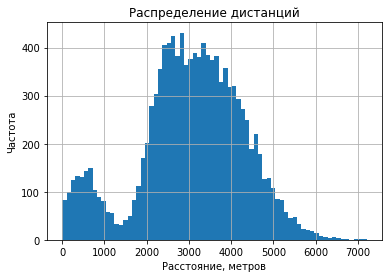

count    11568.000000
mean      3045.992911
std       1246.174341
min          1.000000
25%       2367.000000
50%       3115.000000
75%       3906.000000
max       7212.000000
Name: distance_round, dtype: float64

In [43]:
# посмотрим сколько ездят с бесплатной подпиской
ax = data_free['distance_round'].plot.hist(bins = 70)
ax.set_title('Распределение дистанций')
ax.set_xlabel('Расстояние, метров')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()
data_free['distance_round'].describe()

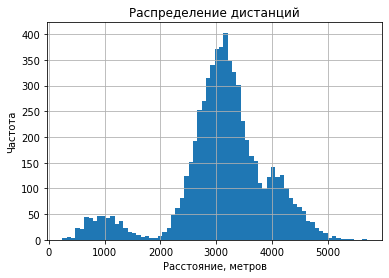

count    6500.000000
mean     3115.949231
std       836.894838
min       245.000000
25%      2786.000000
50%      3149.000000
75%      3561.000000
max      5700.000000
Name: distance_round, dtype: float64

In [44]:
ax = data_ultra['distance_round'].plot.hist(bins = 70)
ax.set_title('Распределение дистанций')
ax.set_xlabel('Расстояние, метров')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()
data_ultra['distance_round'].describe()

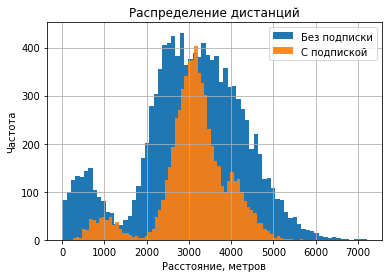

In [45]:
# Построим на одном графике 2 гистограммы, оранжевым обозначены распределения дистанций для пользователей с подпиской, синий - без
ax = data_free['distance_round'].plot.hist(bins = 70)
ax = data_ultra['distance_round'].plot.hist(bins = 70, alpha = 0.9)
ax.set_title('Распределение дистанций')
ax.set_xlabel('Расстояние, метров')
ax.set_ylabel('Частота')
ax.grid(True)
plt.legend(['Без подписки', 'С подпиской'])
plt.show()

Можно сделать следующие выводы:
- Люди с подпиской имеют меньший разброс дистанций
- Люди без подписки также имеют первый максимум левее, чем люди с подпиской, скорее всего это люди пробуют новый вид транспорта
- Если смотреть на малые дистанции, то люди с подпиской гораздо дальше ездят при коротких поездках
- Средние значения имеют практически одинаковые значения (3045 и 3115 метров)

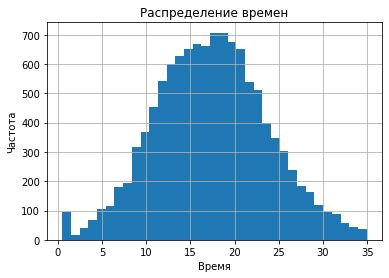

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [46]:
# посмотрим сколько по времени ездят с бесплатной подпиской
ax = data_free['duration'].plot.hist(bins = 35)
ax.set_title('Распределение времен')
ax.set_xlabel('Время')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()
data_free['duration'].describe()

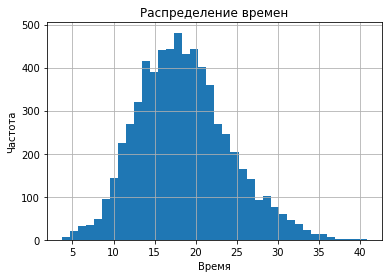

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [47]:
# теперь сколько с платной подпиской
ax = data_ultra['duration'].plot.hist(bins = 38)
ax.set_title('Распределение времен')
ax.set_xlabel('Время')
ax.set_ylabel('Частота')
ax.grid(True)
plt.show()
data_ultra['duration'].describe()

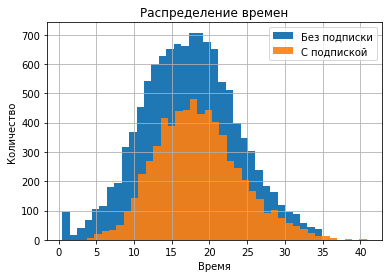

In [48]:
# Построим на одном графике 2 гистограммы, оранжевым обозначены распределения времен для пользователей с подпиской, синий - без
ax = data_free['duration'].plot.hist(bins = 35)
ax = data_ultra['duration'].plot.hist(bins = 38, alpha=0.9)
ax.set_title('Распределение времен')
ax.set_xlabel('Время')
ax.set_ylabel('Количество')
ax.grid(True)
plt.legend(['Без подписки', 'С подпиской'])
plt.show()

Здесь можно отметить следующее:
- В среднем люди с подпиской ездят на минуту дольше, а если учесть, что макимальная продолжительность 41 минута, это не такая уж и маленькая разница
- Много людей без подписки пытались прокатиться на самокате, но сразу же отключались, возможно они бронировали по ошибке, возможно из-за непонимания интерфейса программы
- Разброс времен у людей без подписок снова больше

<b>Итого:</b>
- изначальные данные объеденены в одну таблицу
- созданы 2 датафрейма с людьми с подпиской и без
- рассмотрено поведение людей с подпиской и без:
    - люди с подпиской ездят на 1 минуту дольше
    - люди с подпиской короткую поездку ездят дальше (на 1 км против 500 метров)
    - люди без подписки имеют больший разброс премен и дистанций
- часть людей без подписок арендовали самокат и сразу выключали

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [49]:
# создаем датафрейм с суммарной дистанцией, продролжительностью и количеством поездок каждлого пользователя за месяц
data_group = data.pivot_table(index=['user_id', 'month_number', 'subscription_type'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
data_group

sum               count  \
                                            distance   duration distance   
user_id month_number subscription_type                                     
1       1            ultra               7027.511294  41.416640        2   
        4            ultra                754.159807   6.232113        1   
        8            ultra               6723.470560  44.776802        2   
        10           ultra               5809.911100  31.578017        2   
        11           ultra               7003.499363  53.397424        3   
...                                              ...        ...      ...   
1534    6            free                3409.468534  24.812678        2   
        8            free                7622.453034  47.205960        2   
        9            free                4928.173852  22.560373        1   
        11           free               13350.015305  76.342174        4   
        12           free                2371.711192  15.893917        1   

                                                 
                                       duration  
user_id month_number subscription_type           
1       1            ultra                    2  
        4            ultra                    1  
        8            ultra                    2  
        10           ultra                    2  
        11           ultra                    3  
...                                         ...  
1534    6            free                     2  
        8            free                     2  
        9            free                     1  
        11           free                     4  
        12           free                     1  

[11331 rows x 4 columns]

In [50]:
# переименовываем колонки для простоты
data_group.columns = ['sum_distance', 'sum_duration', 'count_rides', 'count_rides_copy']
data_group

sum_distance  sum_duration  \
user_id month_number subscription_type                               
1       1            ultra               7027.511294     41.416640   
        4            ultra                754.159807      6.232113   
        8            ultra               6723.470560     44.776802   
        10           ultra               5809.911100     31.578017   
        11           ultra               7003.499363     53.397424   
...                                              ...           ...   
1534    6            free                3409.468534     24.812678   
        8            free                7622.453034     47.205960   
        9            free                4928.173852     22.560373   
        11           free               13350.015305     76.342174   
        12           free                2371.711192     15.893917   

                                        count_rides  count_rides_copy  
user_id month_number subscription_type                                 
1       1            ultra                        2                 2  
        4            ultra                        1                 1  
        8            ultra                        2                 2  
        10           ultra                        2                 2  
        11           ultra                        3                 3  
...                                             ...               ...  
1534    6            free                         2                 2  
        8            free                         2                 2  
        9            free                         1                 1  
        11           free                         4                 4  
        12           free                         1                 1  

[11331 rows x 4 columns]

In [51]:
# удаляем лишний столбец с количеством поездок
data_group = data_group.drop(columns='count_rides_copy')
data_group

sum_distance  sum_duration  \
user_id month_number subscription_type                               
1       1            ultra               7027.511294     41.416640   
        4            ultra                754.159807      6.232113   
        8            ultra               6723.470560     44.776802   
        10           ultra               5809.911100     31.578017   
        11           ultra               7003.499363     53.397424   
...                                              ...           ...   
1534    6            free                3409.468534     24.812678   
        8            free                7622.453034     47.205960   
        9            free                4928.173852     22.560373   
        11           free               13350.015305     76.342174   
        12           free                2371.711192     15.893917   

                                        count_rides  
user_id month_number subscription_type               
1       1            ultra                        2  
        4            ultra                        1  
        8            ultra                        2  
        10           ultra                        2  
        11           ultra                        3  
...                                             ...  
1534    6            free                         2  
        8            free                         2  
        9            free                         1  
        11           free                         4  
        12           free                         1  

[11331 rows x 3 columns]

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки

In [52]:
# добавим колонку income_ride - доход с одной поездки
data['income_ride'] = data['start_ride_price'] + data['minute_price'] * data['duration_round']
data

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,distance_round,duration_round,minute_price,start_ride_price,subscription_fee,income_ride
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4410,26,6,0,199,156
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2618,16,6,0,199,96
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,755,7,6,0,199,42
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2695,19,6,0,199,114
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,4029,27,6,0,199,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,3782,20,8,50,0,210
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,2841,22,8,50,0,226
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,3827,19,8,50,0,202
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,2903,17,8,50,0,186


In [53]:
data1 = data.groupby(by=['user_id', 'month_number', 'subscription_type']).sum()
data1

age      distance   duration  \
user_id month_number subscription_type                                 
1       1            ultra               44   7027.511294  41.416640   
        4            ultra               22    754.159807   6.232113   
        8            ultra               44   6723.470560  44.776802   
        10           ultra               44   5809.911100  31.578017   
        11           ultra               66   7003.499363  53.397424   
...                                     ...           ...        ...   
1534    6            free                50   3409.468534  24.812678   
        8            free                50   7622.453034  47.205960   
        9            free                25   4928.173852  22.560373   
        11           free               100  13350.015305  76.342174   
        12           free                25   2371.711192  15.893917   

                                        distance_round  duration_round  \
user_id month_number subscription_type                                   
1       1            ultra                        7028              42   
        4            ultra                         755               7   
        8            ultra                        6724              46   
        10           ultra                        5811              32   
        11           ultra                        7005              56   
...                                                ...             ...   
1534    6            free                         3411              26   
        8            free                         7623              48   
        9            free                         4929              23   
        11           free                        13353              78   
        12           free                         2372              16   

                                        minute_price  start_ride_price  \
user_id month_number subscription_type                                   
1       1            ultra                        12                 0   
        4            ultra                         6                 0   
        8            ultra                        12                 0   
        10           ultra                        12                 0   
        11           ultra                        18                 0   
...                                              ...               ...   
1534    6            free                         16               100   
        8            free                         16               100   
        9            free                          8                50   
        11           free                         32               200   
        12           free                          8                50   

                                        subscription_fee  income_ride  
user_id month_number subscription_type                                 
1       1            ultra                           398          252  
        4            ultra                           199           42  
        8            ultra                           398          276  
        10           ultra                           398          192  
        11           ultra                           597          336  
...                                                  ...          ...  
1534    6            free                              0          308  
        8            free                              0          484  
        9            free                              0          234  
        11           free                              0          824  
        12           free                              0          178  

[11331 rows x 9 columns]

In [54]:
# создадим сводную таблицу с оплатой, здесь столбцы для месячной подписки отдельно
data_group_price = data.pivot_table(index=['user_id', 'month_number', 'subscription_type'], values=['income_ride', 'subscription_fee'], aggfunc=['sum', 'count',])
data_group_price

sum                   \
                                       income_ride subscription_fee   
user_id month_number subscription_type                                
1       1            ultra                     252              398   
        4            ultra                      42              199   
        8            ultra                     276              398   
        10           ultra                     192              398   
        11           ultra                     336              597   
...                                            ...              ...   
1534    6            free                      308                0   
        8            free                      484                0   
        9            free                      234                0   
        11           free                      824                0   
        12           free                      178                0   

                                             count                   
                                       income_ride subscription_fee  
user_id month_number subscription_type                               
1       1            ultra                       2                2  
        4            ultra                       1                1  
        8            ultra                       2                2  
        10           ultra                       2                2  
        11           ultra                       3                3  
...                                            ...              ...  
1534    6            free                        2                2  
        8            free                        2                2  
        9            free                        1                1  
        11           free                        4                4  
        12           free                        1                1  

[11331 rows x 4 columns]

In [55]:
# переименуем столбцы
data_group_price.columns = ['sum_income_ride', 'sum_sub', 'count_rides', 'count_sub']
data_group_price

sum_income_ride  sum_sub  count_rides  \
user_id month_number subscription_type                                          
1       1            ultra                          252      398            2   
        4            ultra                           42      199            1   
        8            ultra                          276      398            2   
        10           ultra                          192      398            2   
        11           ultra                          336      597            3   
...                                                 ...      ...          ...   
1534    6            free                           308        0            2   
        8            free                           484        0            2   
        9            free                           234        0            1   
        11           free                           824        0            4   
        12           free                           178        0            1   

                                        count_sub  
user_id month_number subscription_type             
1       1            ultra                      2  
        4            ultra                      1  
        8            ultra                      2  
        10           ultra                      2  
        11           ultra                      3  
...                                           ...  
1534    6            free                       2  
        8            free                       2  
        9            free                       1  
        11           free                       4  
        12           free                       1  

[11331 rows x 4 columns]

In [56]:
# вернем нормальную цену за подписку
data_group_price['sum_sub'] = (data_group_price['sum_sub']/data_group_price['count_sub']).astype(int)
data_group_price

sum_income_ride  sum_sub  count_rides  \
user_id month_number subscription_type                                          
1       1            ultra                          252      199            2   
        4            ultra                           42      199            1   
        8            ultra                          276      199            2   
        10           ultra                          192      199            2   
        11           ultra                          336      199            3   
...                                                 ...      ...          ...   
1534    6            free                           308        0            2   
        8            free                           484        0            2   
        9            free                           234        0            1   
        11           free                           824        0            4   
        12           free                           178        0            1   

                                        count_sub  
user_id month_number subscription_type             
1       1            ultra                      2  
        4            ultra                      1  
        8            ultra                      2  
        10           ultra                      2  
        11           ultra                      3  
...                                           ...  
1534    6            free                       2  
        8            free                       2  
        9            free                       1  
        11           free                       4  
        12           free                       1  

[11331 rows x 4 columns]

In [57]:
# удалим ненужные столбцы с количеством поездок
data_group_price = data_group_price.drop(columns=['count_rides', 'count_sub'])
#data_group_price['sum'] = data_group_price['sum_price'] + data_group_price['sum_sub']
data_group_price

sum_income_ride  sum_sub
user_id month_number subscription_type                          
1       1            ultra                          252      199
        4            ultra                           42      199
        8            ultra                          276      199
        10           ultra                          192      199
        11           ultra                          336      199
...                                                 ...      ...
1534    6            free                           308        0
        8            free                           484        0
        9            free                           234        0
        11           free                           824        0
        12           free                           178        0

[11331 rows x 2 columns]

In [58]:
# столбец с суммарным доходом за месяц
data_group_price['income_month'] = data_group_price['sum_income_ride'] + data_group_price['sum_sub']
data_group_price

sum_income_ride  sum_sub  income_month
user_id month_number subscription_type                                        
1       1            ultra                          252      199           451
        4            ultra                           42      199           241
        8            ultra                          276      199           475
        10           ultra                          192      199           391
        11           ultra                          336      199           535
...                                                 ...      ...           ...
1534    6            free                           308        0           308
        8            free                           484        0           484
        9            free                           234        0           234
        11           free                           824        0           824
        12           free                           178        0           178

[11331 rows x 3 columns]

In [59]:
# соединим с таблицей из предыдущего пункта
data_group_sum = data_group.merge(data_group_price, on=['user_id', 'month_number', 'subscription_type'])
data_group_sum

sum_distance  sum_duration  \
user_id month_number subscription_type                               
1       1            ultra               7027.511294     41.416640   
        4            ultra                754.159807      6.232113   
        8            ultra               6723.470560     44.776802   
        10           ultra               5809.911100     31.578017   
        11           ultra               7003.499363     53.397424   
...                                              ...           ...   
1534    6            free                3409.468534     24.812678   
        8            free                7622.453034     47.205960   
        9            free                4928.173852     22.560373   
        11           free               13350.015305     76.342174   
        12           free                2371.711192     15.893917   

                                        count_rides  sum_income_ride  sum_sub  \
user_id month_number subscription_type                                          
1       1            ultra                        2              252      199   
        4            ultra                        1               42      199   
        8            ultra                        2              276      199   
        10           ultra                        2              192      199   
        11           ultra                        3              336      199   
...                                             ...              ...      ...   
1534    6            free                         2              308        0   
        8            free                         2              484        0   
        9            free                         1              234        0   
        11           free                         4              824        0   
        12           free                         1              178        0   

                                        income_month  
user_id month_number subscription_type                
1       1            ultra                       451  
        4            ultra                       241  
        8            ultra                       475  
        10           ultra                       391  
        11           ultra                       535  
...                                              ...  
1534    6            free                        308  
        8            free                        484  
        9            free                        234  
        11           free                        824  
        12           free                        178  

[11331 rows x 6 columns]

#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Гипотеза следующая: пользователи с подпиской тратят больше времени на поездки

Нулевую гипотезу составим таким образом: пользователи с подпиской и без одинаково ездят по времени

Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки

Для ее подсчета используем ttest_ind о двух разных генеральных совокупностях, т.к. у нас разные размерности, то equal_var = False 

In [60]:
results = st.ttest_ind(data_ultra['duration'],data_free['duration'], equal_var=False, alternative='greater')
print(f'p-value: {results.pvalue}')

p-value: 5.6757813771289775e-37


p-value <i> очень мало</i>, соответственно нулевую гипотезе о равенстве стоит отвергнуть. Скорее всего пользователи с подпиской катаются дольше, чем пользователи без подписки

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза: люди проезжают 3130 метров
Альернативная гипотеза: люди проезжают больше 3130 метров

На графике у нас 2 пика, оба имеют вид нормального распределения, значит выборочное среднее тоже будет нормально распределено

In [63]:
dist = 3130

results = st.ttest_1samp(data_ultra['distance'], dist, alternative='greater')
print(f'p-value: {results.pvalue}')

p-value: 0.9195368847849785


P-значение 0.92, значит мы не можем отвергать нулевую гипотезу о равенстве среднего расстояния поездки 3130 метрам и она скорее всего верна, значит самокаты не будут изнашиваться

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Проверим следующую гипотезу: помесячная выручка от людей с подпиской выше, чем от людей без подписки. Альтернативная гипотеза: помесячная выручка от людей с подпиской меньше, чем от людей без подписки

Будем рассматривать сколько каждый человек потратил в месяц

In [65]:
# Напечатаем еще раз таблицу из более ранних шагов
data_group_sum

sum_distance  sum_duration  \
user_id month_number subscription_type                               
1       1            ultra               7027.511294     41.416640   
        4            ultra                754.159807      6.232113   
        8            ultra               6723.470560     44.776802   
        10           ultra               5809.911100     31.578017   
        11           ultra               7003.499363     53.397424   
...                                              ...           ...   
1534    6            free                3409.468534     24.812678   
        8            free                7622.453034     47.205960   
        9            free                4928.173852     22.560373   
        11           free               13350.015305     76.342174   
        12           free                2371.711192     15.893917   

                                        count_rides  sum_income_ride  sum_sub  \
user_id month_number subscription_type                                          
1       1            ultra                        2              252      199   
        4            ultra                        1               42      199   
        8            ultra                        2              276      199   
        10           ultra                        2              192      199   
        11           ultra                        3              336      199   
...                                             ...              ...      ...   
1534    6            free                         2              308        0   
        8            free                         2              484        0   
        9            free                         1              234        0   
        11           free                         4              824        0   
        12           free                         1              178        0   

                                        income_month  
user_id month_number subscription_type                
1       1            ultra                       451  
        4            ultra                       241  
        8            ultra                       475  
        10           ultra                       391  
        11           ultra                       535  
...                                              ...  
1534    6            free                        308  
        8            free                        484  
        9            free                        234  
        11           free                        824  
        12           free                        178  

[11331 rows x 6 columns]

In [66]:
# переведем индексы в столбцы в таблице с доходом по месяцам
data_group_sum.reset_index(inplace= True, level=['subscription_type', 'month_number'])
print(data_group_sum)

         month_number subscription_type  sum_distance  sum_duration  \
user_id                                                               
1                   1             ultra   7027.511294     41.416640   
1                   4             ultra    754.159807      6.232113   
1                   8             ultra   6723.470560     44.776802   
1                  10             ultra   5809.911100     31.578017   
1                  11             ultra   7003.499363     53.397424   
...               ...               ...           ...           ...   
1534                6              free   3409.468534     24.812678   
1534                8              free   7622.453034     47.205960   
1534                9              free   4928.173852     22.560373   
1534               11              free  13350.015305     76.342174   
1534               12              free   2371.711192     15.893917   

         count_rides  sum_income_ride  sum_sub  income_month  
user_id      

In [67]:
# проведем ttest, данные имеют неравные знчения генеральной совокупности, соотвтетственно equal_var=False
for i in (data_group_sum['month_number'].sort_values().unique()):
    arr1 = data_group_sum[(data_group_sum['month_number'] == i) & (data_group_sum['subscription_type'] == 'ultra')]['income_month'] 
    arr2 = data_group_sum[(data_group_sum['month_number'] == i) & (data_group_sum['subscription_type'] == 'free')]['income_month']
    results = st.ttest_ind(arr1, arr2, equal_var = False, alternative='less')
    print(f'p-значение в номере месяца {i} равняется {results.pvalue}')

p-значение в номере месяца 1 равняется 0.9999998977181809
p-значение в номере месяца 2 равняется 0.9999889008403645
p-значение в номере месяца 3 равняется 0.9944391624717124
p-значение в номере месяца 4 равняется 0.9997320796715885
p-значение в номере месяца 5 равняется 0.9999944773958577
p-значение в номере месяца 6 равняется 0.9999737681810137
p-значение в номере месяца 7 равняется 0.9999866629531736
p-значение в номере месяца 8 равняется 0.9994148761098438
p-значение в номере месяца 9 равняется 0.9995323039940404
p-значение в номере месяца 10 равняется 0.9993668181162226
p-значение в номере месяца 11 равняется 0.9999810012183423
p-значение в номере месяца 12 равняется 0.9997984049737871


Значения p-value равны почти 1, соотвтетственно нулевая гипотеза о том, что доход с платных подписчиков больше чем с простых многовероятен

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Данные выборки имеют зависимость, соответственно надо провести ttest_rel
Нулевая гипотеза что осталось на прежнем уровне
Альтернативная, что уменьшилось

In [79]:
# пример
# results = st.ttest_rel(before, after, alternative='less')
# print(('p-значение:', results.pvalue))

# Заключение
В данной работе были рассмотренны все первоначальные задачи:
- была изучена база данных
- Были построены графики:
    - частоты городов (количество клиентов почти равномерно распределено между городами, макс. 219 в Пятигорске, мин. 168 в Москве)
    - соотношения числа пользователей по подписке (45.6% пользователей оформили подписку ультра)
    - возрастов пользователей (наибольшее количество клиентв имеют возраст 20-30 лет)
    - расстояние одной поездки (поездки делятся условно на короткие (500 метров в среднем) и длинные (3 км в среднем), при этом количесво длинных поездок сильно больше, чем коротких (90% поездок против 10%)
    - продолжительность поездок (в среднем люди с подпиской катаются 18 минут, а люди без подписки - 17 минут
- Изучены поездки людей с подпиской и без
- Была подсчитана выручка от каждого пользователя
- Проверены следующие гипотезы:
    - гипотеза о равенстве времен поездок скорее всего неверна и люди с подпиской ездят дольше (p-value порядка 1e-32)
    - гипотеза о среднем расстоянии поездки 3130 метров скорее всего верна (p_value = 0.92)
    - гипотеза о том, что <b>люди с подпиской выгодны для компании</b> также скорее всего <b>верна</b>, во все месяца значение p-value стремилось к 1

Исходя из результатов проверки последней гипотезы можно говорить о том, что люди, покупающие подписку выгодны компании в сравнении с людьми, не покупающими подписку

#### Шаг 7. Распределения

##### 
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [80]:
number = 1168 # количсетво пробников
alpha = 0.05 # вероятность не выполнить
prob = 0.1 # шанс подпсики
sub=100

mu = number*prob # мат ожидание
sigma = sqrt(number*prob*(1-prob)) #дисперсия

distr = st.norm(mu, sigma)

result = distr.cdf(sub)
print(result)

0.050650790692463


Вывод: минимальное количество подписок составляет 1168, чтобы шанс на успех был 95%